In [54]:
import os
import re

from dotenv import load_dotenv
load_dotenv()

import random
import json
import pprint

import math
import numpy as np
import pandas as pd
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.expand_frame_repr', False)

from preprocessing import scripts, pretrained_models

# import spacy
# import contractions
# from unidecode import unidecode
# from word2number import w2n

# import matplotlib.pyplot as plt
# %matplotlib inline

from wordcloud import WordCloud

from importlib import reload
reload(scripts)
reload(pretrained_models)

pp = pprint.PrettyPrinter(indent=2)

In [ ]:
# import clean exhibit and gallery datasets

home = os.getenv("PROJ_HOME")
exhibits_filepath = os.path.join(home, "data/institutional/exhibits.json")
galleries_filepath = os.path.join(home, "data/institutional/galleries.json")

with open(exhibits_filepath, 'r') as file:
    exhibits = json.load(file)

with open(galleries_filepath, 'r') as file:
    galleries = json.load(file)

In [8]:
# investigate presense of missing data

N_exh = len(exhibits)

def count_perc(count):
    return count, count/N

missing_data = {
    'id': exhibits['id'].isnull().sum(),
    'title': exhibits['title'].isnull().sum(),
    'aliases': exhibits['aliases'].apply(lambda x: 1 if x == [''] else 0).sum(),   # why isn't this working???
    'creators': exhibits['creators'].apply(lambda x: 1 if len(x) == 0 else 0).sum(),
    'year': exhibits['year'].isnull().sum(),
    'location':exhibits['location'].isnull().sum(),
    'about': exhibits['about'].isnull().sum(),
    'subjects': exhibits['subjects'].apply(lambda x: 1 if len(x) == 0 else 0).sum(),
    'collections': exhibits['collections'].apply(lambda  x: 1 if len(x) == 0 else 0).sum(0),
    'related': exhibits['related'].apply(lambda x: 1 if len(x) == 0 else 0).sum(),
}

label = 'Missing data by column label'
print(label + '\n' + '='*len(label))
for k, v in missing_data.items():
    val, per = count_perc(v)
    print(f'{k}: {val}, {per:0.2%}')

Dataframe exhibits_df contains 183 rows

Missing data by column label
exhibit_id: 0, 0.00%
title: 0, 0.00%
alias: 98, 53.55%
creator_name: 22, 12.02%
created_date: 33, 18.03%
location: 19, 10.38%
about: 40, 21.86%
subjects: 54, 29.51%
collections: 70, 38.25%
related: 25, 13.66%


In [10]:
# store galleries data in dataframe with the following columns:
# 'gallery_id', 'title', 'about', 'curator_statement'

galleries_df = pd.DataFrame({'gallery_id': pd.Series(dtype='str'),
                             'title': pd.Series(dtype='str'),
                             'about': pd.Series(dtype='str'),
                             'curator_statement': pd.Series(dtype='str'),
                             })

for gallery in galleries:
    # directly copy several key: value pairs
    these_keys = ['id',
                  'title',
                  'tagline',
                  'description',
                  'curator_statement']
    this_data = {k: v for k, v in gallery.items() if k in these_keys}

    # rename some keys
    this_data['gallery_id'] = this_data.pop('id')

    # define 'about' as 'tagline' + 'description'
    this_data['about'] = ' '.join([this_data.pop('tagline'),
                                   this_data.pop('description')])

    this_row = pd.DataFrame(data=this_data, index=[0])
    galleries_df = pd.concat([galleries_df, this_row], ignore_index=True)

galleries_df.head(10)

,gallery_id,title,about,curator_statement
0,gallery-2,Gallery 2: Tinkering,Explore your creativity and our curious contra...,"A tall, fanciful, interactive Tinkerer’s Clock..."
1,gallery-1,Bernard and Barbro Osher Gallery 1: Human Phen...,"Experiment with thoughts, feelings, and social...",The experiences in the Osher Gallery focus on ...
2,gallery-6,Fisher Bay Observatory Gallery 6: Observing La...,"Uncover the history, geography, and ecology of...","This second-floor, indoor/outdoor exhibition s..."
3,gallery-3,Bechtel Gallery 3: Seeing & Reflections,"Experiment with light, mirrors, and bubbles. O...",Bechtel Gallery 3 is the heart of the Explorat...
4,gallery-4,Gordon and Betty Moore Gallery 4: Living Systems,Explore life from DNA and cells to organisms a...,Gallery 4 fosters an appreciation of the livin...
5,gallery-5,Gallery 5: Outdoor Exhibits,"Explore winds, tides, and natural phenomena. I...",The guiding principle of the Gallery 5 is to s...


In [13]:
# define the text processing pipeline

# deselected_stop_words = ['one', 'two']
# for w in deselected_stop_words:
#     nlp.vocab[w].is_stop = False

def remove_whitespace(text):
    text = ' '.join(text.strip().split())
    return text

def remove_accents(text):
    text = unidecode(text)
    return text

def expand_contractions(text):
    text = contractions.fix(text)
    return text

def preprocess(text,
               accented_chars=True,
               contractions=True,
               convert_num=True,
               whitespace=True,
               lemmatization=True,
               lowercase=True,
               punctuation=True,
               remove_num=False,
               special_chars=True,
               stop_words=True):

    if whitespace:
        text = remove_whitespace(text)
    if accented_chars:
        text = remove_accents(text)
    if contractions:
        text = expand_contractions(text)
    if lowercase:
        text = text.lower()

    doc = nlp(text)
    clean_text = []

    for token in doc:
        flag = False
        this_token = token.text
        if stop_words and token.is_stop and token.pos_ != 'NUM':  # removes stop words which aren't numbers
            flag = True
        elif punctuation and token.pos_ == 'PUNCT':  # removes punctuation
            flag = True
        elif special_chars and token.pos_ == 'SYM':  # removes special characters
            flag = True
        elif remove_num and (token.pos_ == 'NUM' or token.text.isnumeric()):  # removes numbers
            flag = True
        if convert_num and token.pos_ == 'NUM' and not flag:  # converts number words to numerals
            try:
                this_token = w2n.word_to_num(token.text)
            except ValueError:
                pass
        if lemmatization and token.lemma_ != "-PRON-" and not flag:  # gets lemmas, ignoring pronouns
            this_token = token.lemma_
        if this_token != "" and not flag:  # appends (converted and/or lemmatized) unflagged tokens to clean_text
            clean_text.append(this_token)

    return clean_text

In [14]:
# import data and store in a dataframe with columns 'article_id', 'source', 'title', and 'pre_heading_text'

curr_path = os.getcwd()
data_path = os.path.join(curr_path, '../knowledgebase/encyclopedia/prehead_text/')

articles_df = pd.DataFrame({'article_id': pd.Series(dtype='str'),
                            'source_code': pd.Series(dtype='int'),
                            'title': pd.Series(dtype='str'),
                            'text': pd.Series(dtype='str')})

for filename in os.listdir(data_path):
    if filename.startswith('.'):
        continue
    filepath = os.path.join(data_path, filename)
    with open(filepath, 'r') as infile:
        new_data = json.load(infile)
        new_df = pd.DataFrame(data=new_data, index=[0])
    articles_df = pd.concat([articles_df, new_df], ignore_index=True)

articles_df = articles_df.rename(columns={'text': 'pre_heading_text'})

# add a column to the dataframe which stores the processed text (a list of tokens)
articles_df['tokens'] = articles_df['pre_heading_text'].apply(lambda text: preprocess(text))

print('{} articles imported'.format(len(articles_df)))

576 articles imported


In [15]:
# investigate distribution of article length (number of characters) by source:
#  1: Avanced
# 31: Intermediate
# 45: Concise

articles_df['article_len'] = articles_df['pre_heading_text'].apply(lambda text: len(text))
print('Article length (characters):\n{}\n'.format(articles_df.groupby(['source_code'])['article_len'].describe()))

Article length (characters):
             count    mean     std    min    25%     50%     75%      max
source_code                                                              
1           347.00 1932.86 1627.46  65.00 769.00 1496.00 2549.50 10856.00
31           76.00 1546.58 1107.27 309.00 742.00 1161.50 2081.75  4850.00
45          153.00  765.56  302.39 268.00 567.00  676.00  886.00  2294.00



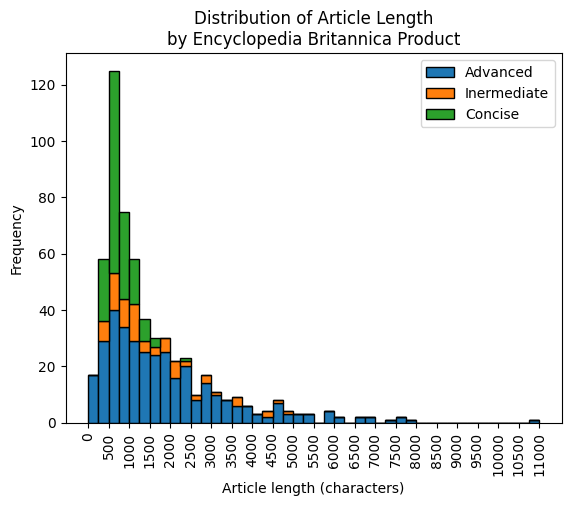

In [16]:
# plot distirubtion of article length by source

def round_up(num, delta):
    num = math.ceil(num / delta) * delta
    return num

def make_int(values, d):
    return np.arange(0, round_up(values.max(), d) + d, d, dtype=int)

delta = 250
endpoints = make_int(articles_df['article_len'], delta)
xticks = make_int(articles_df['article_len'], 2 * delta)

plt.hist([articles_df['article_len'][articles_df.source_code == 1],
          articles_df['article_len'][articles_df.source_code == 31],
          articles_df['article_len'][articles_df.source_code == 45]],
         histtype='bar', stacked=True, label=['Advanced', 'Inermediate', 'Concise'],
         bins=endpoints, edgecolor='black')

plt.xlabel('Article length (characters)')
plt.xticks(xticks, rotation='vertical')
plt.ylabel('Frequency')
plt.title('Distribution of Article Length\nby Encyclopedia Britannica Product')
plt.legend()
plt.show()

In [17]:
# investigate the distribution of the number of tokens (post-processing) per article by source:
#  1: Avanced
# 31: Intermediate
# 45: Concise

num_tokens = articles_df['tokens'].str.len()
articles_df['num_tokens'] = articles_df['tokens'].apply(lambda lst: len(lst))
print('Number of tokens (post-processing):\n{}\n'.format(articles_df.groupby(['source_code'])['num_tokens'].describe()))

Number of tokens (post-processing):
             count   mean    std   min   25%    50%    75%    max
source_code                                                      
1           347.00 163.81 136.30  7.00 66.00 126.00 214.00 830.00
31           76.00 134.04 100.79 29.00 62.75  96.00 171.25 433.00
45          153.00  68.00  28.14 23.00 49.00  61.00  79.00 208.00



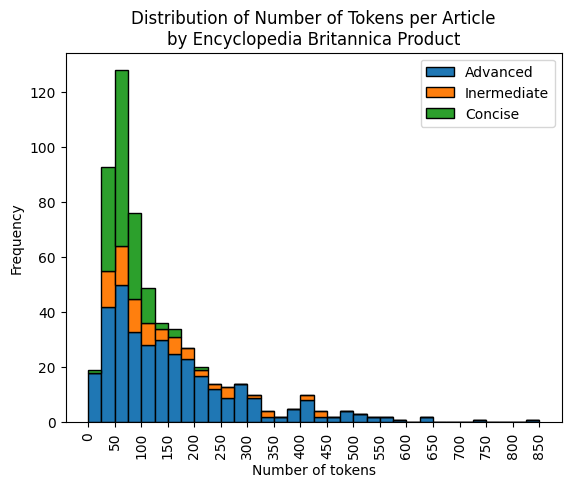

In [18]:
# plot distirubtion of number of tokens per article by source

delta = 25
endpoints = make_int(articles_df['num_tokens'], delta)
xticks = make_int(articles_df['num_tokens'], 2 * delta)

plt.hist([articles_df['num_tokens'][articles_df.source_code == 1],
          articles_df['num_tokens'][articles_df.source_code == 31],
          articles_df['num_tokens'][articles_df.source_code == 45]],
         histtype='bar', stacked=True, label=['Advanced', 'Inermediate', 'Concise'],
         bins=endpoints, edgecolor='black')

plt.xlabel('Number of tokens')
plt.xticks(xticks, rotation='vertical')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Tokens per Article\nby Encyclopedia Britannica Product')
plt.legend()
plt.show()

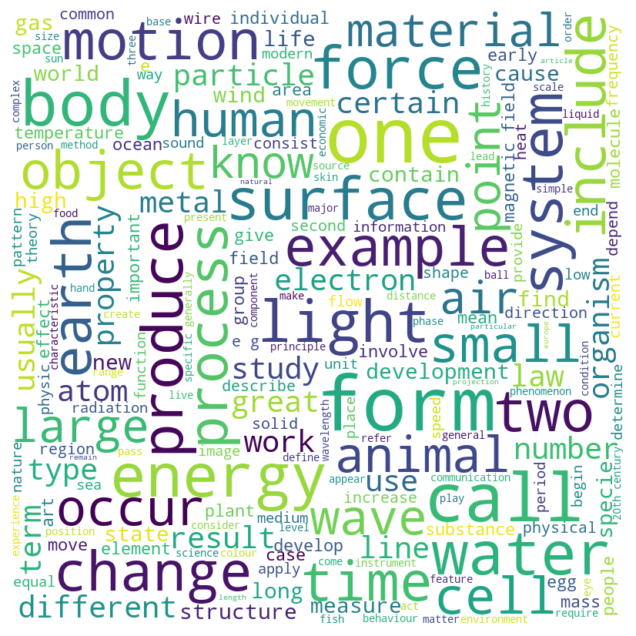

In [19]:
# visualize wordcloud of all (pre-processed) tokens across all articles

list_of_lists = articles_df['tokens'].tolist()
token_list = [token for sublist in list_of_lists for token in sublist]
token_str = ' '.join(token_list)

wordcloud = WordCloud(width = 800,
                      height = 800,
                      background_color='white',
                      min_font_size=10,
                      max_font_size=100).generate(token_str)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# create wordcloud of unique keywords

# fix reference to unique_keywords
words = " ".join(unique_keywords)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()